In [34]:
from keras import models
from keras import layers
from keras import backend

In [35]:
import numpy as np
import colorsys
import sqlalchemy as db
from ftplib import FTP

In [36]:
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [37]:
ftpFilePath = '/home/shiwarai/WebsiteForDownloading/Website/colors-sets.db'
datasetPath = r"C:\Users\bager\YandexDisk\Проекты\RidrameCraft_сайт\Нейронная сеть\ColorCombinationsDataset"

In [38]:
ftp = FTP('185.253.217.111','shiwarai','7412369pav')
if ftp.getwelcome() != None:
    with open(datasetPath + r'\colors-sets.db', 'wb') as file:
        ftp.retrbinary('RETR %s' % ftpFilePath, file.write)
ftp.close()

from sqlalchemy import create_engine
engine = create_engine('sqlite:///'+datasetPath+r'\colors-sets.db', echo=False)

from sqlalchemy import Column, Integer, String, SmallInteger
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

Base = declarative_base()   
class ColorCombination(Base):
    __tablename__ = 'color_combination' 
    
    num =  Column(Integer(),primary_key=True,autoincrement=True )
    color_1 = Column(String(7),nullable=False)
    color_2 = Column(String(7),nullable=False)
    color_3 = Column(String(7),nullable=True)
    color_4 = Column(String(7),nullable=True)
    color_5 = Column(String(7),nullable=True)
    size =  Column(SmallInteger(),nullable=False)

    def __repr__(self):
        return '<Color set #%d: %s,%s,%s,%s,%s [%d colors]>' % (self.num,self.color_1,self.color_2,self.color_3,self.color_4,self.color_5,self.size)

Base.metadata.create_all(engine)
session = sessionmaker(bind=engine)()

In [39]:
# Функции для чтения данных

def hex_to_rgb(h):
    h = h[1:]
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))

def rgb_to_hsv(rgb):
    r, g, b = [x/255.0 for x in [rgb[0], rgb[1], rgb[2]]]
    h, l, s = colorsys.rgb_to_hsv(r, g, b)
    return [h, l, s]

def hsv_to_rgb(hsv):
    r, g, b = colorsys.hsv_to_rgb(hsv[0], hsv[1], hsv[2])
    r, g, b = [x*255.0 for x in [r, g, b]]
    return [r, g, b]

def hex_to_hsv(h):
    return rgb_to_hsv(hex_to_rgb(h))

def hsv_to_hex(hsv):
    return rgb_to_hex(hsv_to_rgb(hsv))

In [40]:
input_dataset_train = list()
output_dataset_train = list()

color_combination_objects = session.query(ColorCombination).filter_by(size = 2)
for color_comb_obj in color_combination_objects:
    input_dataset_train.append(hex_to_rgb(color_comb_obj.color_1))
    output_dataset_train.append(hex_to_rgb(color_comb_obj.color_2))
    
    input_dataset_train.append(hex_to_rgb(color_comb_obj.color_2))
    output_dataset_train.append(hex_to_rgb(color_comb_obj.color_1))

color_combination_objects = session.query(ColorCombination).filter_by(size = 3)
for color_comb_obj in color_combination_objects:
    input_dataset_train.append(hex_to_rgb(color_comb_obj.color_1))
    output_dataset_train.append(hex_to_rgb(color_comb_obj.color_3))
    
    input_dataset_train.append(hex_to_rgb(color_comb_obj.color_3))
    output_dataset_train.append(hex_to_rgb(color_comb_obj.color_1))
    
    input_dataset_train.append(hex_to_rgb(color_comb_obj.color_2))
    output_dataset_train.append(hex_to_rgb(color_comb_obj.color_3))
    
    input_dataset_train.append(hex_to_rgb(color_comb_obj.color_3))
    output_dataset_train.append(hex_to_rgb(color_comb_obj.color_2))
    
train_size = round(4/5*len(input_dataset_train))
train_data = np.array([input_dataset_train[:train_size],output_dataset_train[:train_size]], dtype="int")
validation_data = np.array([input_dataset_train[train_size:],output_dataset_train[train_size:]], dtype="int")

print("Train data: ", train_size)
print("Validation data: ", len(input_dataset_train) - train_size)

print("Closing database...")
session.close()

Train data:  376
Validation data:  94
Closing database...


In [41]:
def build_model_shade():
    model = models.Sequential()
    model.add(layers.Dense(1028, activation='relu',input_shape = [3,]))
    model.add(layers.Dropout(0.5, noise_shape=None, seed=None))
    model.add(layers.Dense(3, activation='relu'))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

In [42]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu',input_shape = [3,]))
    model.add(layers.Dropout(0.5, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.4, noise_shape=None, seed=None))
    model.add(layers.Dense(3, activation='relu'))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

In [43]:
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

In [44]:
build_model().summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 195       
Total params: 17,667
Trainable params: 17,667
Non-trainable params: 0
_________________________________________________________________


In [45]:
build_model_shade().summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1028)              4112      
_________________________________________________________________
dropout_9 (Dropout)          (None, 1028)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 3087      
Total params: 7,199
Trainable params: 7,199
Non-trainable params: 0
_________________________________________________________________


shuffle_in_unison(train_data[0],train_data[1])
history_dict = model.fit(train_data[0],train_data[1],epochs = 200, batch_size = 64, validation_data = (validation_data[0],validation_data[1])).history

In [58]:
def build_and_fit():
    model = build_model()
    shuffle_in_unison(train_data[0],train_data[1])
    shuffle_in_unison(validation_data[0],validation_data[1])
    return [model, model.fit(train_data[0],train_data[1],epochs = 50, batch_size = 32, validation_data = (validation_data[0],validation_data[1])).history]
    
generated_model = build_and_fit()
model = generated_model[0]
history_dict = generated_model[1]
del generated_model

Epoch 1/50
12/12 [==============================] - 2s 40ms/step - loss: 12109.4769 - mae: 90.7045 - val_loss: 5144.9111 - val_mae: 57.8837
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 8035.4885 - mae: 73.6700 - val_loss: 5000.0327 - val_mae: 56.6684
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 7808.0777 - mae: 72.7839 - val_loss: 5155.9565 - val_mae: 57.8946
Epoch 4/50
12/12 [==============================] - 0s 7ms/step - loss: 8418.9855 - mae: 75.5877 - val_loss: 4957.2788 - val_mae: 56.3278
Epoch 5/50
12/12 [==============================] - 0s 6ms/step - loss: 7947.4179 - mae: 73.5765 - val_loss: 5110.8716 - val_mae: 57.4628
Epoch 6/50
12/12 [==============================] - 0s 6ms/step - loss: 6989.5057 - mae: 69.3004 - val_loss: 5318.7295 - val_mae: 58.8004
Epoch 7/50
12/12 [==============================] - 0s 6ms/step - loss: 7096.1853 - mae: 70.5687 - val_loss: 5326.2578 - val_mae: 58.9023
Epoch 8/50
12/12 [==============

Min num: 49
Min value: 54.81080627441406


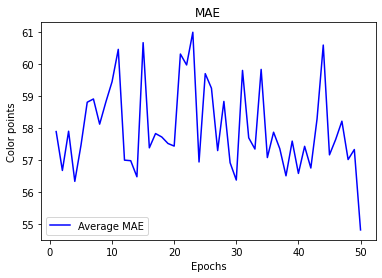

In [59]:
best_epoch = history_dict['val_mae'].index(min(history_dict['val_mae']))

print("Min num:", best_epoch)
print("Min value:", history_dict['val_mae'][best_epoch])

epochs = range(1,len(history_dict) + 1)

def curve(points):
    return points

smooth_mae_history = curve(history_dict['val_mae'])
epochs = range(1,len(history_dict['val_mae'])+1)


plt.plot(epochs,smooth_mae_history,'b',label = 'Average MAE')
plt.title('MAE')
plt.xlabel("Epochs")
plt.ylabel('Color points')
plt.legend()
plt.show()

In [60]:
print("Final value:", history_dict['val_mae'][len(history_dict['val_mae'])-1])

Final value: 54.81080627441406


In [49]:
def post_processing(colors):
    '''
    for i in range(len(colors)):
        colors[i] = hsv_to_rgb(colors[i])
    '''
    
    processed_colors = list()
    for color in colors:
        red = color[0]
        green = color[1]
        blue = color[2]
        
        # Увеличим доминирующий цвет
        dominant_color = colors.argmax()
        passive_color = colors.argmax()
        
        if dominant_color == 0:
            red *= 1.2
        elif dominant_color == 1:
            green *= 1.2
        elif dominant_color == 2:
            blue *= 1.2
            
        if passive_color == 0:
            red *= 0.8
        elif passive_color == 1:
            green *= 0.8
        elif passive_color == 2:
            blue *= 0.8
        
        red = min(round(red), 255)
        green = min(round(green), 255)
        blue = min(round(blue), 255)

        processed_colors.append([red, green, blue])

    return processed_colors

# Предсказание
def predict(rgb_colors_set):
    '''
    hsv_colors_set = list()
    for color_set in rgb_colors_set:
        hsv_colors_set.append(rgb_to_hsv(color_set))
    '''
    
    prediction = post_processing(model.predict(np.array(rgb_colors_set)))

    return prediction
predict([[22,22,200],])

[[118, 86, 119]]

In [50]:
color_picker_1 = widgets.ColorPicker(concise=False, value = '#ffffff', description='Pick a color №1')
color_picker_2 = widgets.ColorPicker(concise=False, value = '#ffffff', description='Pick a color №2')
color_picker_3 = widgets.ColorPicker(concise=False, value = '#ffffff', description='Pick a color №3')
color_picker_4 = widgets.ColorPicker(concise=False, value = '#ffffff', description='Pick a color №4')
color_picker_5 = widgets.ColorPicker(concise=False, value = '#ffffff', description='Pick a color №5')

In [51]:
color_picker_1

ColorPicker(value='#ffffff', description='Pick a color №1')

In [52]:
color_picker_2

ColorPicker(value='#ffffff', description='Pick a color №2')

In [53]:
color_picker_3

ColorPicker(value='#ffffff', description='Pick a color №3')

In [54]:
color_picker_4

ColorPicker(value='#ffffff', description='Pick a color №4')

In [55]:
color_picker_5

ColorPicker(value='#ffffff', description='Pick a color №5')

[(224, 62, 62), [156, 148, 152]]
[(209, 113, 113), [134, 126, 128]]
[(46, 108, 209), [134, 139, 119]]
[(70, 210, 105), [107, 128, 129]]
[(241, 203, 65), [149, 151, 137]]


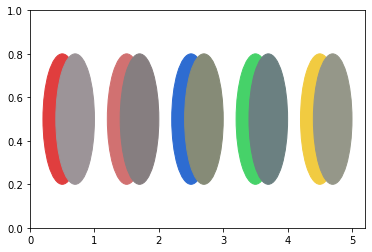

In [61]:
color_sets = [hex_to_rgb(color_picker_1.value),hex_to_rgb(color_picker_2.value),hex_to_rgb(color_picker_3.value),hex_to_rgb(color_picker_4.value),hex_to_rgb(color_picker_5.value)]
sets_and_predictions = list()
for color_set in color_sets:
    sets_and_predictions.append([color_set, predict([color_set,])[0]])
    
fig, ax = plt.subplots()
ax.set_xlim((0, len(sets_and_predictions) + 0.2))

circle_counter = 0.5
for set_and_prediction in sets_and_predictions:
    print(set_and_prediction)
    ax.add_patch(plt.Circle((circle_counter, 0.5), 0.3, color=rgb_to_hex(set_and_prediction[0])))
    ax.add_patch(plt.Circle((circle_counter + 0.2, 0.5), 0.3, color=rgb_to_hex(set_and_prediction[1])))
    circle_counter += 1